In [1]:
import os

os.chdir('../')

## Imports

In [2]:
import rasterio
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

## Handlers

In [3]:
def load_tif(file_path, verbose=1):
    # Load raster data
    with rasterio.open(file_path) as src:
        
        if verbose>0:
            print(f"Plik: {file_path}")
            print("Liczba kanałów:", src.count)
            print("Rozmiar (szer, wys):", src.width, src.height)
            print("Rozdzielczość:", src.res)
            print("CRS (układ współrzędnych):", src.crs)
            
            print("Opisy kanałów:", src.descriptions)
            print("Podsumowanie pliku:", src.profile)
        
        data = src.read()
        
        return data

In [4]:
data_path = Path('./data')
main_tif_path = data_path.joinpath("TerenyInwestycyjneKonin_transparent_mosaic_group1.tif")

main_tif = load_tif(main_tif_path)

Plik: data\TerenyInwestycyjneKonin_transparent_mosaic_group1.tif
Liczba kanałów: 4
Rozmiar (szer, wys): 4713 5015
Rozdzielczość: (0.442079715680034, 0.4420749152542373)
CRS (układ współrzędnych): EPSG:2177
Opisy kanałów: (None, None, None, None)
Podsumowanie pliku: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 4713, 'height': 5015, 'count': 4, 'crs': CRS.from_wkt('PROJCS["ETRF2000-PL / CS2000/18",GEOGCS["ETRF2000-PL",DATUM["ETRF2000_Poland",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","1305"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","9702"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",18],PARAMETER["scale_factor",0.999923],PARAMETER["false_easting",6500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Northing",NORTH],AXIS["Easting",EAST],AUTHORITY["EPSG","2177"]]'

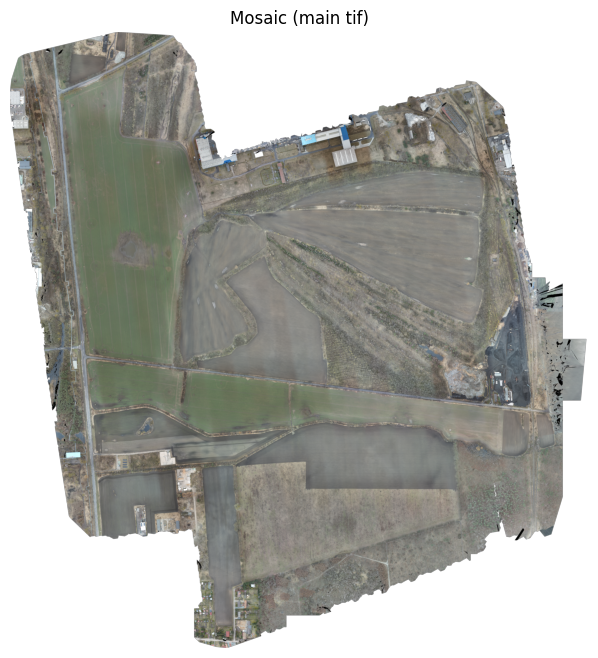

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

ax.imshow(main_tif.swapaxes(0,1).swapaxes(1,2))
ax.set_title("Mosaic (main tif)")

plt.axis("off")
plt.show()

In [6]:
import rasterio
import numpy as np
import os

# Ścieżka wejściowa i wyjściowa
input_path = main_tif_path
output_dir = "tiles_100m"

# Rozmiar w metrach i pikselach
tile_size_m = 100
pixel_size_m = 0.44
tile_size_px = int(tile_size_m / pixel_size_m)


# Wczytaj plik
with rasterio.open(input_path) as src:
    width, height = src.width, src.height
    profile = src.profile

    num_tiles_x = width // tile_size_px
    num_tiles_y = height // tile_size_px

    print(f"Rozmiar rastra: {width}x{height}")
    print(f"Kafelek: {tile_size_px}x{tile_size_px} px ≈ {tile_size_m}x{tile_size_m} m")
    print(f"Ilość kafelków: {num_tiles_x} x {num_tiles_y} = {num_tiles_x * num_tiles_y}")
    
    tiles = []    
    for i in range(num_tiles_y):
        x_tiles = []
        for j in range(num_tiles_x):
            window = rasterio.windows.Window(
                col_off=j * tile_size_px,
                row_off=i * tile_size_px,
                width=tile_size_px,
                height=tile_size_px
            )
            transform = rasterio.windows.transform(window, src.transform)
            tile_data = src.read(window=window)
            
            x_tiles.append(tile_data)
        tiles.append(x_tiles)

Rozmiar rastra: 4713x5015
Kafelek: 227x227 px ≈ 100x100 m
Ilość kafelków: 20 x 22 = 440


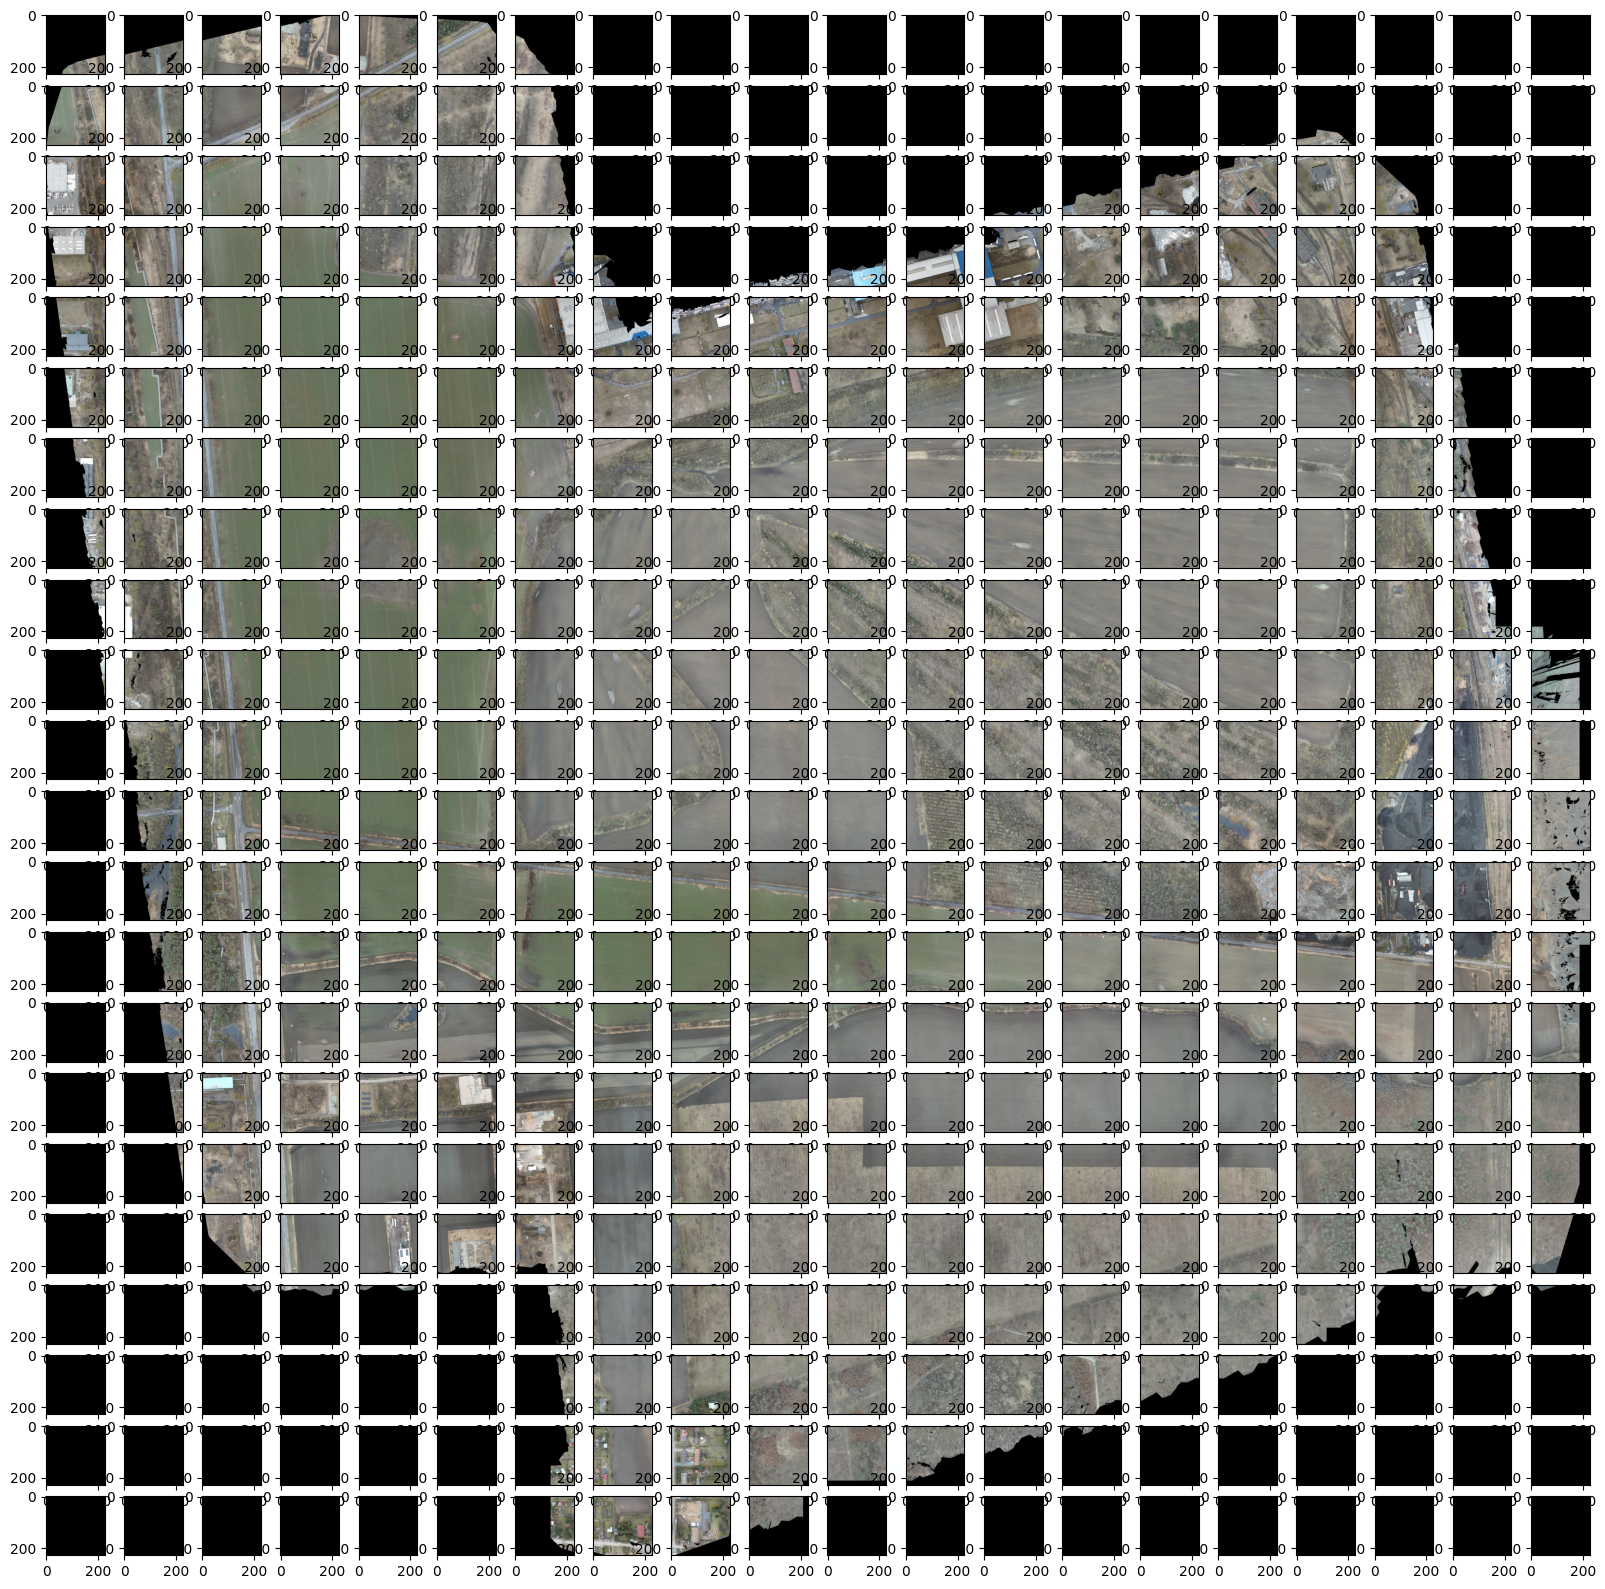

In [7]:
fig, axs = plt.subplots(num_tiles_y, num_tiles_x, figsize=(20,20))
for i in range(num_tiles_y):
    for j in range(num_tiles_x):
        axs[i][j].imshow(tiles[i][j].swapaxes(0,1).swapaxes(1,2)[:,:,:3])

plt.show()

In [8]:
import rasterio
import numpy as np
from sklearn.cluster import KMeans
import os
from tqdm import tqdm
from collections import Counter


# Parametry
background_threshold = 10  # wartość "ciemna", np. piksel 0–10
background_fraction = 0.5  # jeżeli > 50% to tło
n_clusters = 5           # liczba klastrów KMeans

def is_background(tile, threshold=background_threshold, frac=background_fraction):
    mask = tile[0] <= threshold
    return (np.mean(mask) > frac)

def cluster_tile(tile, n_clusters=4):
    # Zakładamy dane RGB (3 kanały), ewentualnie 4 z czwartym do pominięcia
    tile_rgb = tile[:3]  # shape (3, H, W)
    h, w = tile_rgb.shape[1], tile_rgb.shape[2]
    reshaped = tile_rgb.reshape(3, -1).T  # shape (N, 3)

    kmeans = KMeans(n_clusters=n_clusters, n_init="auto", random_state=0)
    labels = kmeans.fit_predict(reshaped)
    return labels.reshape(h, w)

# Przetwarzamy kafelki
tiles_labels = []
for i in range(num_tiles_y):
    x_tiles_lables = []
    for j in range(num_tiles_x):
        tile = tiles[i][j]

        if is_background(tile):
            x_tiles_lables.append(-1)
            continue


        clustered = cluster_tile(tile, n_clusters=n_clusters).astype("uint8")
        dominant_label = Counter(clustered.flatten()).most_common(1)
        dominant_label = int(dominant_label[0][0])
        
        x_tiles_lables.append(dominant_label)
    
    tiles_labels.append(x_tiles_lables)

In [ ]:
# fig, axs = plt.subplots(num_tiles_y, num_tiles_x, figsize=(20,20))
# for i in range(num_tiles_y):
#     for j in range(num_tiles_x):
#         axs[i][j].imshow(tiles[i][j].swapaxes(0,1).swapaxes(1,2)[:,:,:3])
#         axs[i][j].imshow(tiles_labels[i][j])
        

# plt.show()

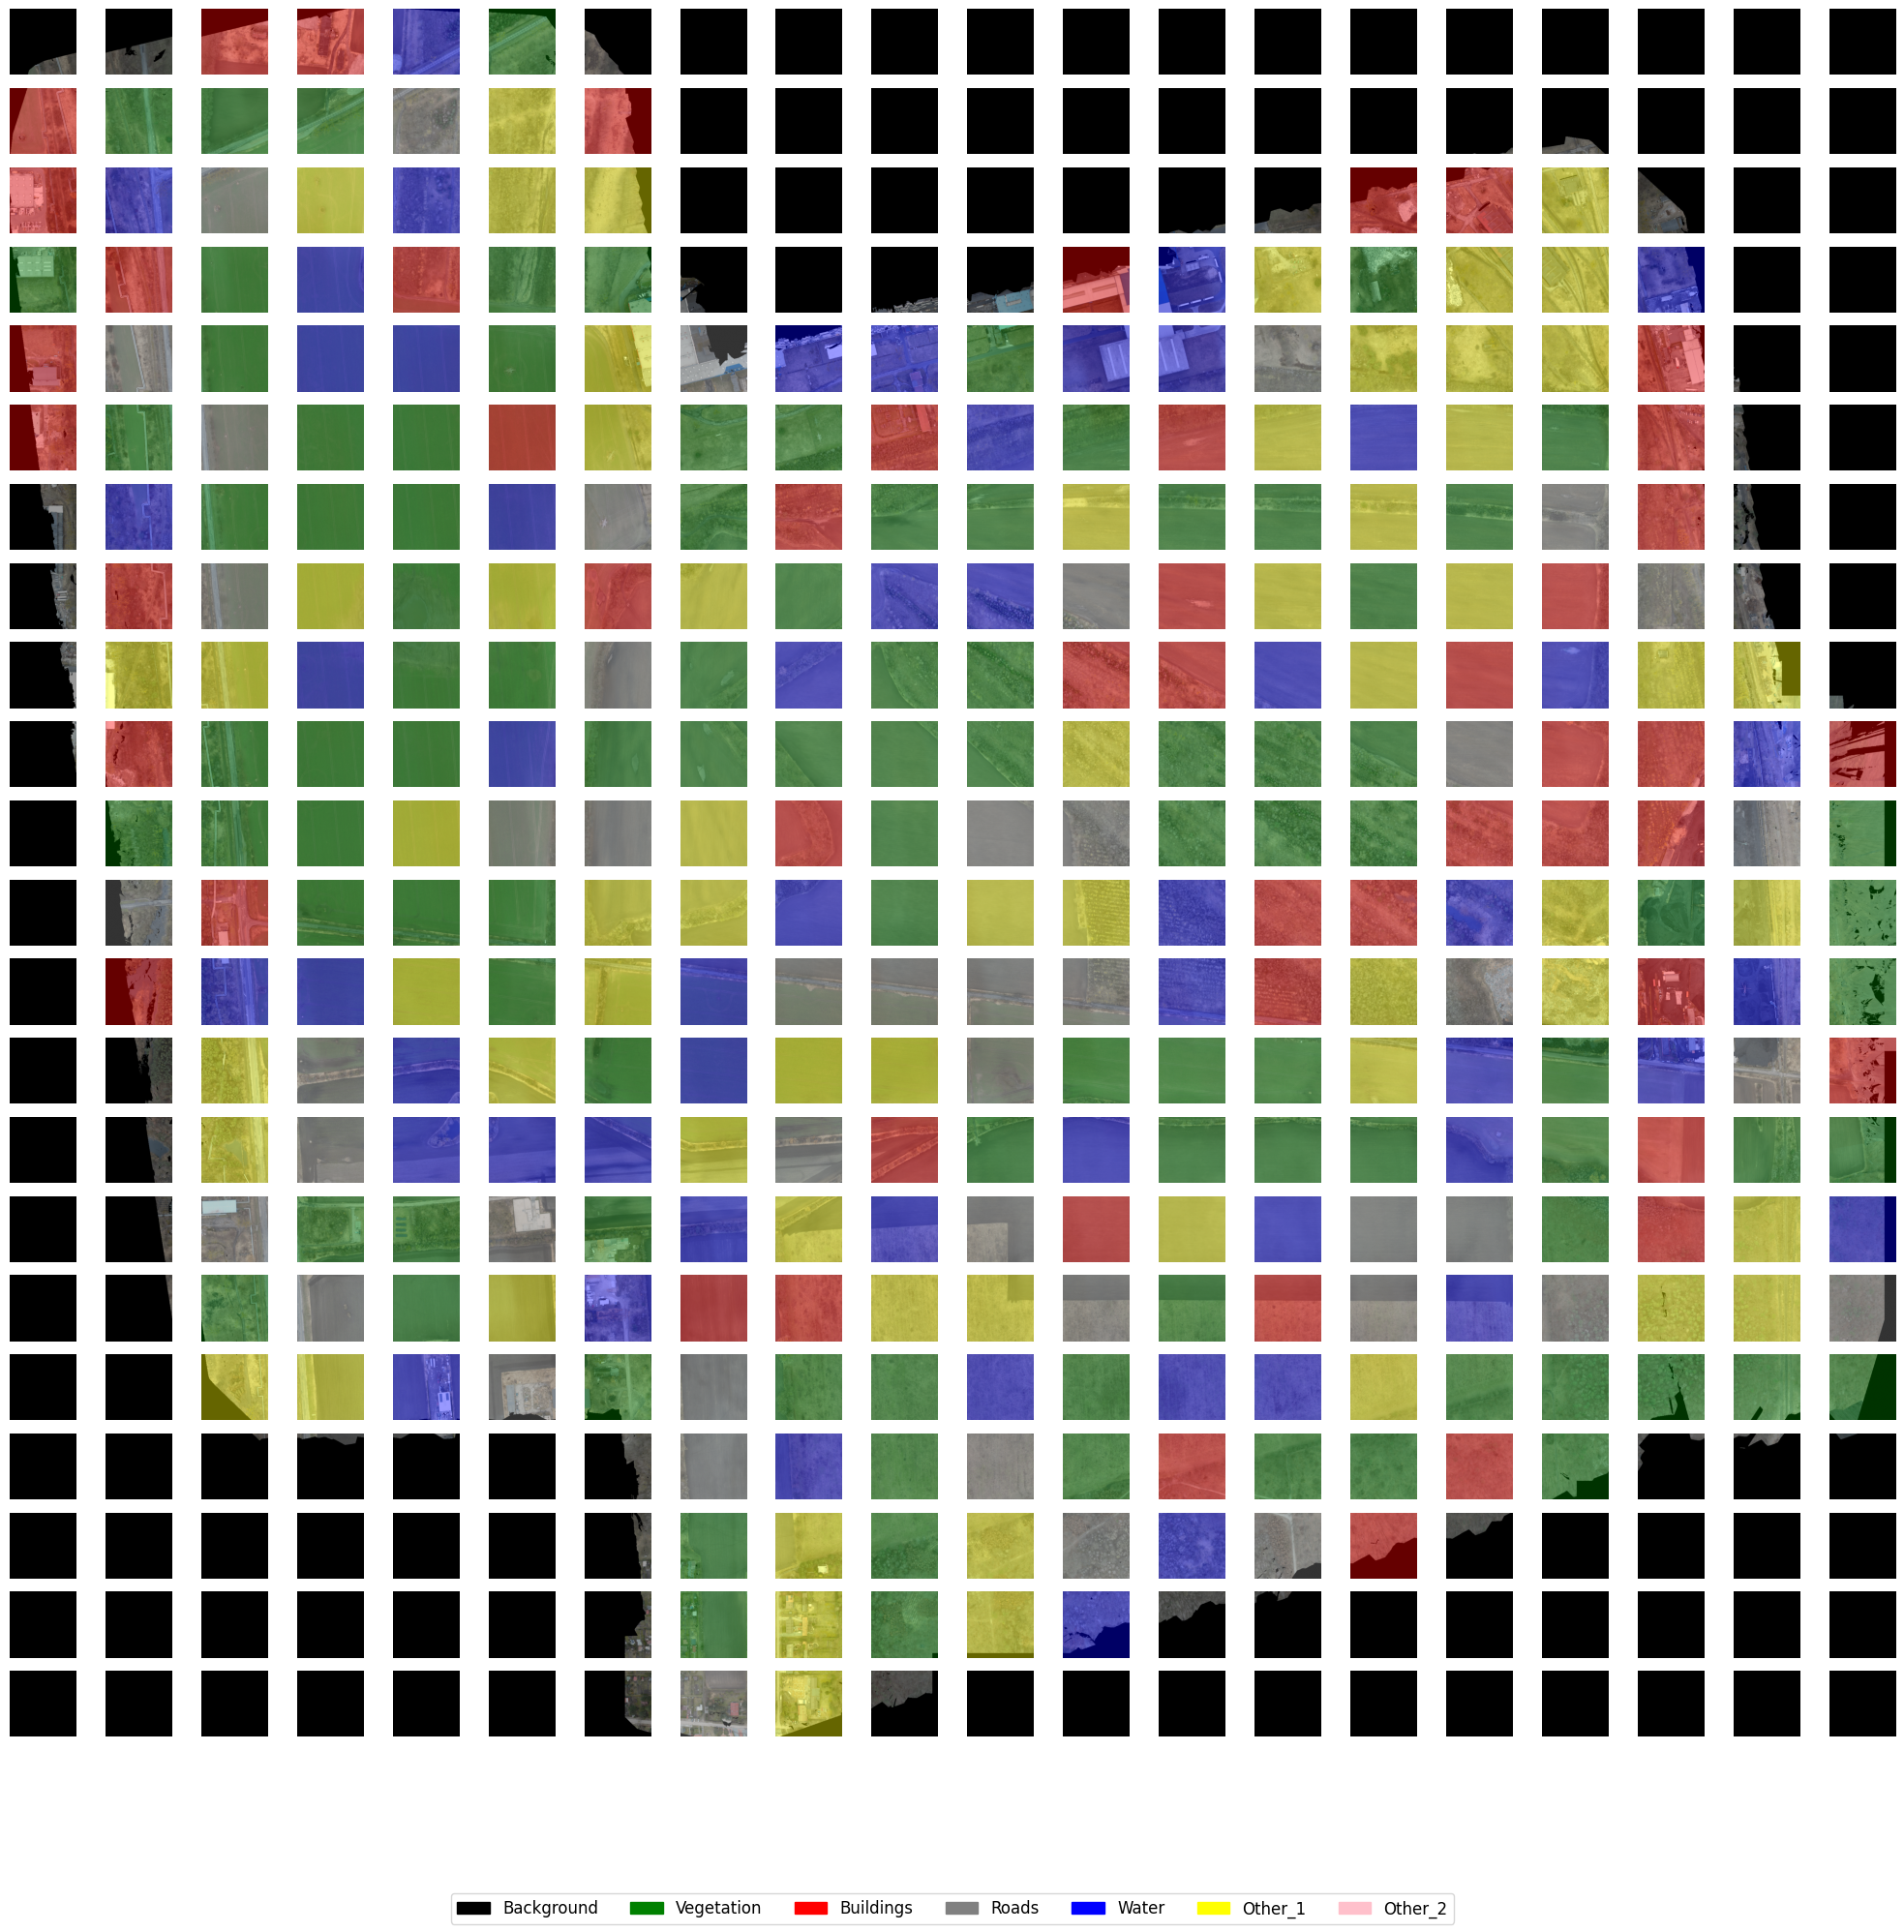

In [11]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

# Define label names and corresponding colors
label_colors = {
    -1: ('Background', 'black'),
    0: ('Vegetation', 'green'),
    1: ('Buildings', 'red'),
    2: ('Roads', 'gray'),
    3: ('Water', 'blue'),
    4: ('Other_1', 'yellow'),
    5: ('Other_2', 'pink'),
    # 6: ('Other_3', 'violet'),
}
# You can adjust this based on your own label scheme

# Build colormap and legend
cmap = ListedColormap([label_colors[i][1] for i in range(-1, len(label_colors)-1)])
legend_handles = [
    mpatches.Patch(color=color, label=name)
    for i, (name, color) in label_colors.items()
]

# Plot with overlay
fig, axs = plt.subplots(num_tiles_y, num_tiles_x, figsize=(20, 20))

for i in range(num_tiles_y):
    for j in range(num_tiles_x):
        axs[i][j].imshow(tiles[i][j].swapaxes(0, 1).swapaxes(1, 2)[:,:,:3])  # RGB
        axs[i][j].imshow(
            (np.zeros(shape=tiles[i][j].shape[1:])+1)*tiles_labels[i][j],
            cmap=cmap,
            alpha=0.4, # parametr przeźroczystości
            vmin=-1,
            vmax=len(label_colors) - 2
        )
        axs[i][j].axis('off')

fig.legend(
    handles=legend_handles,
    loc='lower center',
    ncol=len(label_colors),
    fontsize='large'
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)  # Leave space for legend
plt.show()


In [16]:
import pandas as pd
import numpy as np


records = []
for i in range(num_tiles_y):
    for j in range(num_tiles_x):
        records.append({
            "row": i,
            "col": j,
            "label": label_colors[tiles_labels[i][j]][0],
            "tile_id": tiles_labels[i][j]
        })

df = pd.DataFrame.from_records(records)
df.to_csv(data_path.joinpath("tile_labels.csv"), index=True)

print("✅ Saved to tile_labels.csv")


✅ Saved to tile_labels.csv
